In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go

# Set the default renderer for plotly
import plotly.io as pio
pio.renderers.default='png' #! Comment this out to make plots non-interactive

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
holiday_events = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')
stores = pd.read_csv('data/stores.csv')
transactions = pd.read_csv('data/transactions.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print("train.csv")
print(train.head())
print("\n")
# print("test.csv")
# print(test.head())
# print("\n")
# print("stores.csv")
# print(stores.head())
# print("\n")
print("transactions.csv")
print(transactions.head())
print("\n")
print("oil.csv")
print(oil.head())
print("\n")
print("holidays_events.csv")
print(holiday_events.head())
print("\n")

# Convert date to datetime
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holiday_events['date'] = pd.to_datetime(holiday_events['date']) #Just added

# Fix other datatypes
train.onpromotion = train.onpromotion.astype("float32")
test.onpromotion = test.onpromotion.astype("float32")

# Rename columns
oil.columns = ['date', 'oil_price']

train.sales = train.sales.astype("float32")
# train.id = train.id.astype("float32") # We use floats because there can be fractional sales (ex: half pound of meat)

stores.cluster = stores.cluster.astype("category") # Maybe make this int8


train.csv
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0


transactions.csv
         date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922


oil.csv
         date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20


holidays_events.csv
         date     type    locale locale_name                    description  transferred
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta        False
1  20

# Seasonality
Typically, I like to begin data analysis projects by just graphing things to see if there are any obvious patterns. I'll then make a list of subjects to explore.

From the training data, we can see spikes in transactions at the end of the year around Christmas time. It would be benifical to consider holidays in our final analysis.

In [3]:
df = train.copy()
df = train.groupby(['date', 'store_nbr']).sum().reset_index()

df = df.merge(transactions, on=['date', 'store_nbr'], how='left')

print("Correlation between sales per day and transactions per day: R^2 = ", df['sales'].corr(df['transactions'])**2)

Correlation between sales per day and transactions per day: R^2 =  0.7012114277374502


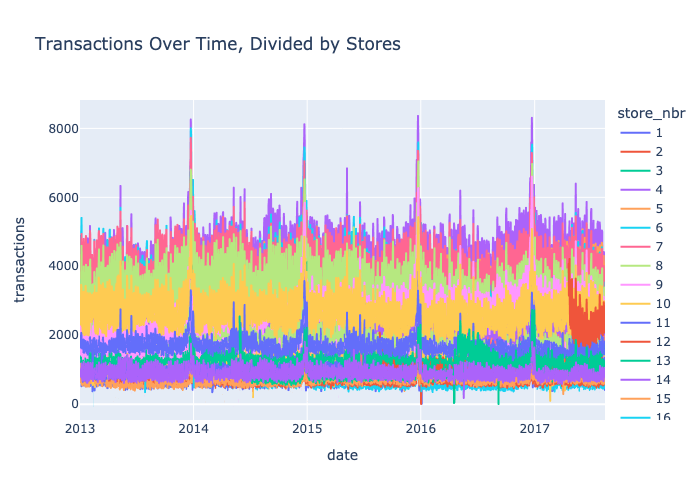

In [4]:
# Transaction Line Plot
px.line(transactions.sort_values(["store_nbr", "date"]), x='date', y='transactions', color='store_nbr',title = "Transactions Over Time, Divided by Stores" )

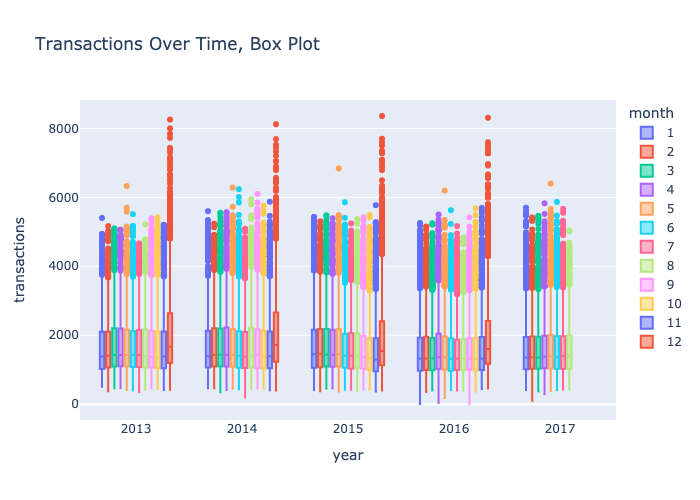

In [5]:
# Transaction Box Plot
temp = transactions.copy()
temp["year"] = temp.date.dt.year
temp["month"] = temp.date.dt.month

px.box(temp, x='year', y='transactions',color='month', title = "Transactions Over Time, Box Plot")

Let's also consider day of the week. As we can see, weekends have more transactions than weekdays.

/var/folders/mx/13dxfl6n7mnbgt5sbs2rylyc0000gn/T/ipykernel_86267/833768698.py:6: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



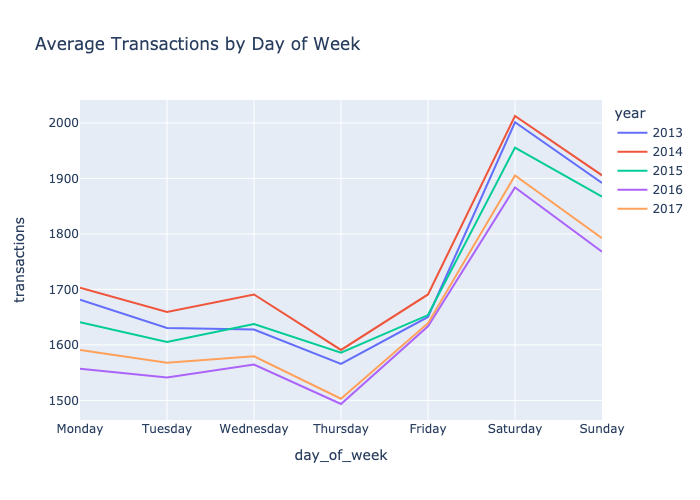

In [6]:
temp = transactions.copy()
temp["year"] = temp.date.dt.year
temp["day_of_week"] = temp.date.dt.day_name()

temp = temp.groupby(["year", "day_of_week"]).mean().reset_index()
temp["day_of_week_number"] = temp["day_of_week"].replace({"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7})

temp.sort_values(["year", "day_of_week_number"], inplace = True)

px.line(temp, x='day_of_week', y='transactions', color ="year", title = "Average Transactions by Day of Week")

According to the dataset source, most Ecuadoorians are paid on the 15th and 30th of the month. Let's see which parts of the month have the most transactions.

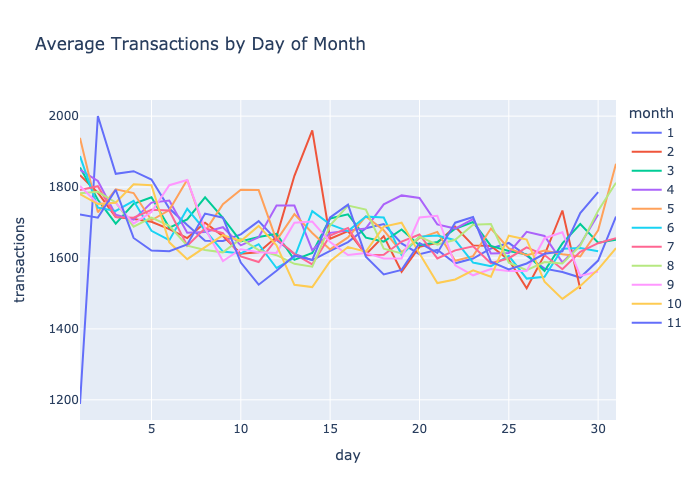

In [7]:
temp = transactions.copy()
temp["year"] = temp.date.dt.year
temp["month"] = temp.date.dt.month
temp["day"] = temp.date.dt.day

temp = temp.groupby(["month", "day"]).mean().reset_index()
# Delete december, because it's an outlier
temp = temp[temp.month != 12]

# Transactions throughout each month
px.line(temp, x='day', y='transactions', color ="month", title = "Average Transactions by Day of Month")

There's no obvious increase in transactions on payday, so maybe we should look at sales.

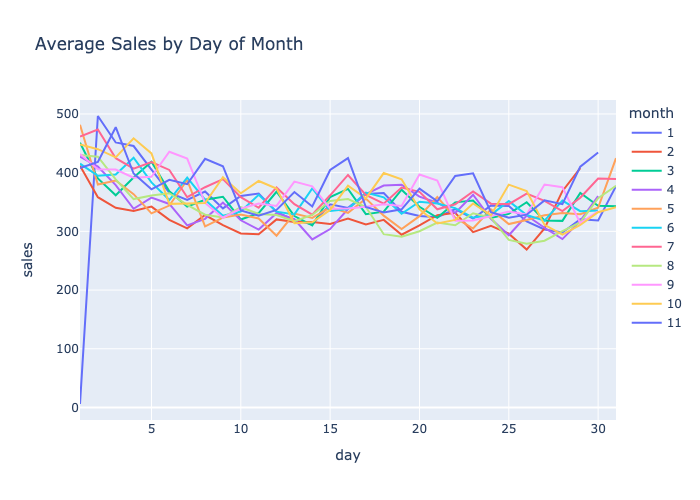

In [8]:
temp = train.copy()
temp["year"] = temp.date.dt.year
temp["month"] = temp.date.dt.month
temp["day"] = temp.date.dt.day

del temp["family"]

temp = temp.groupby(["month", "day"]).mean().reset_index()
# Delete december, because it's an outlier
temp = temp[temp.month != 12]

# Sales throughout each month
px.line(temp, x='day', y='sales', color ="month", title = "Average Sales by Day of Month")

If there's a correlation between payday and sales, it's not obvious.

# Oil Prices

The Ecuadorian economy is heavily dependent on oil prices. Let's see if there's a correlation between oil prices and transactions.

Let's start by plotting oil prices.

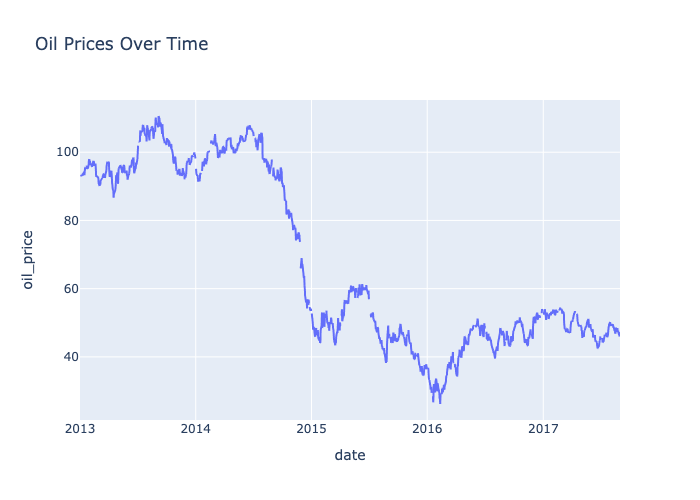

In [9]:
px.line(oil, x='date', y='oil_price', title = "Oil Prices Over Time")

We can see there's missing data here. Let's interpolate the missing data.

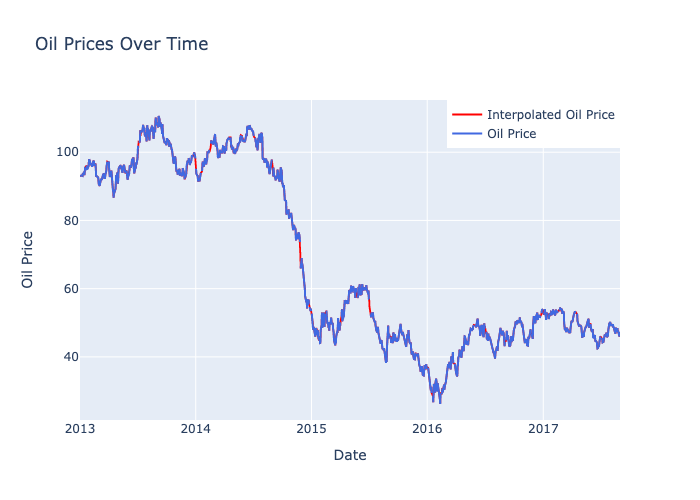

In [10]:
oil["interpolated_oil_price"] = oil["oil_price"].interpolate()

fig = go.Figure()

fig.add_trace(go.Scatter(x=oil.date, y=oil.interpolated_oil_price, mode='lines', name='Interpolated Oil Price', line=dict(color='red', width=1.8)))
fig.add_trace(go.Scatter(x=oil.date, y=oil.oil_price, mode='lines', name='Oil Price', line=dict(color='royalblue', width=2)))

fig.update_layout(title='Oil Prices Over Time',
                     xaxis_title='Date',
                     yaxis_title='Oil Price',
                     legend = dict(x=.68, y=1, traceorder='normal'),)

fig.show()

Let's calculate the correlation between oil prices and transactions.

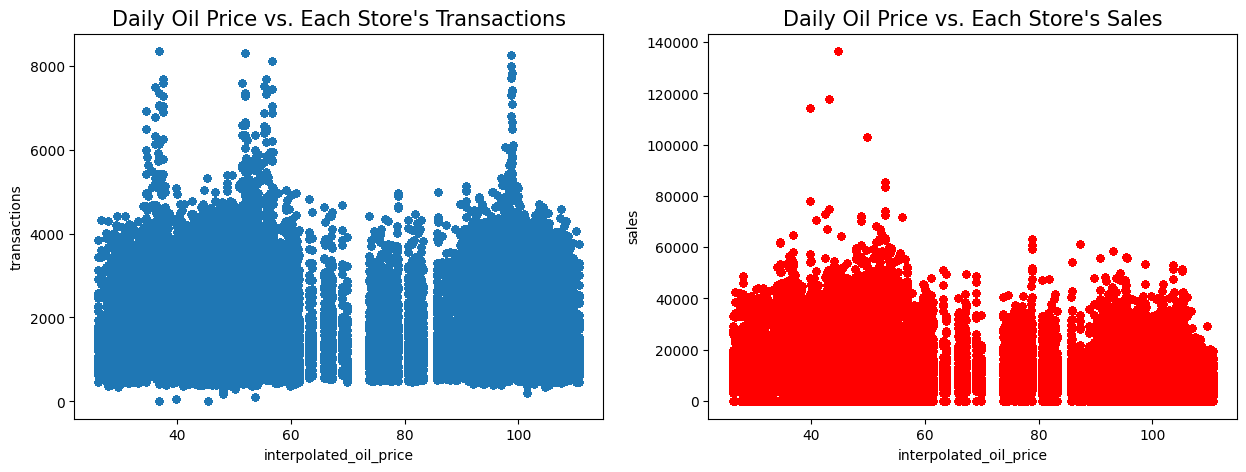

In [11]:
# Get sales data
temp_sales = train.copy()
temp_sales = temp_sales.groupby(["date","store_nbr"]).sum().reset_index()

# Get transactions data
temp = transactions.copy()

# Merge sales, transactions, and oil data
temp = temp.merge(oil, on="date", how="left")
temp = temp.merge(temp_sales, on="date", how="left")

# Plot
fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "interpolated_oil_price", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "interpolated_oil_price", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily Oil Price vs. Each Store\'s Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price vs. Each Store\'s Sales', fontsize = 15);

Let's also calculate correlation.

In [12]:
Transaction_Oil_Pearson = temp[["interpolated_oil_price", "transactions"]].corr().iloc[0,1]
Transaction_Oil_Spearman = temp[["interpolated_oil_price", "transactions"]].corr(method = "spearman").iloc[0,1]

Sales_Oil_Pearson = temp[["interpolated_oil_price", "sales"]].corr().iloc[0,1]
Sales_Oil_Spearman = temp[["interpolated_oil_price", "sales"]].corr(method = "spearman").iloc[0,1]

print(f"Correlation between Oil Price and ...\n=============================================\n")

print("Transactions and Oil Price Correlation:")
print(f"Pearson:  {Transaction_Oil_Pearson}")
print(f"Spearman: {Transaction_Oil_Spearman}\n")

print("---------------------------------------------\n")

print("Sales and Oil Price Correlation:")
print(f"Pearson:  {Sales_Oil_Pearson}")
print(f"Spearman: {Sales_Oil_Spearman}")

Correlation between Oil Price and ...

Transactions and Oil Price Correlation:
Pearson:  0.02189991922356999
Spearman: 0.03796356802633895

---------------------------------------------

Sales and Oil Price Correlation:
Pearson:  -0.2965359801809939
Spearman: -0.31448878610710085


The correlation numbers above are for individual stores. What about the correlation between oil prices and sales/transactions for all the stores?

Correlation between Oil Price and Transactions

Transactions:
Pearson:  0.021899919223588152
Spearman: 0.037963568026522655

---------------------------------------------

Sales:
Pearson:  -0.6968923214134068
Spearman: -0.6442672838551617


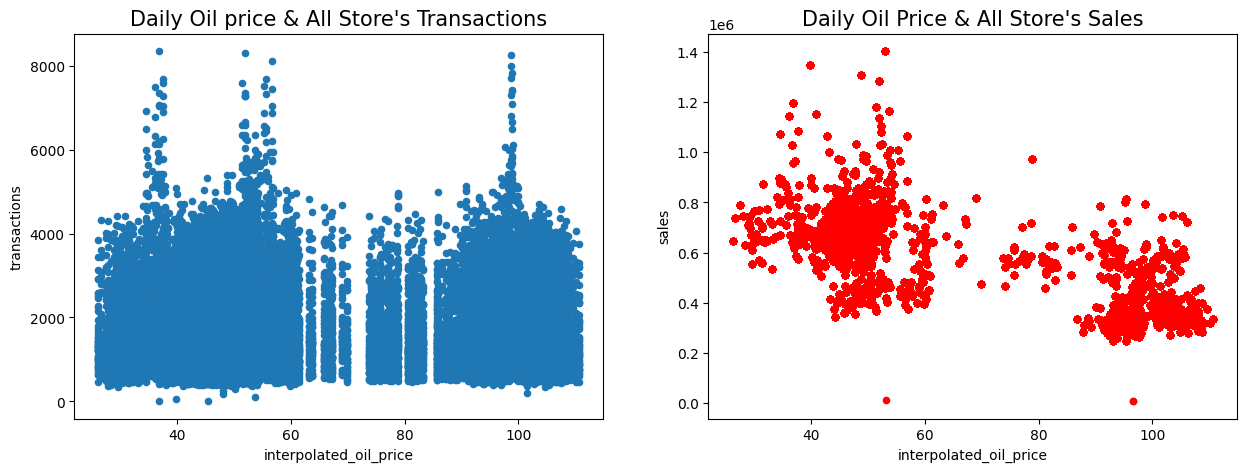

In [13]:
temp_sales = train.copy()
temp_sales = temp_sales.groupby(["date"]).sum().reset_index()

temp = transactions.copy()

temp = temp.merge(oil, on="date", how="left")
temp = temp.merge(temp_sales, on="date", how="left")

Transaction_Oil_Pearson = temp[["interpolated_oil_price", "transactions"]].corr().iloc[0,1]
Transaction_Oil_Spearman = temp[["interpolated_oil_price", "transactions"]].corr(method = "spearman").iloc[0,1]

Sales_Oil_Pearson = temp[["interpolated_oil_price", "sales"]].corr().iloc[0,1]
Sales_Oil_Spearman = temp[["interpolated_oil_price", "sales"]].corr(method = "spearman").iloc[0,1]

print(f"Correlation between Oil Price and Transactions\n=============================================\n")

print("Transactions:")
print(f"Pearson:  {Transaction_Oil_Pearson}")
print(f"Spearman: {Transaction_Oil_Spearman}\n")

print("---------------------------------------------\n")

print("Sales:")
print(f"Pearson:  {Sales_Oil_Pearson}")
print(f"Spearman: {Sales_Oil_Spearman}")

fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "interpolated_oil_price", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "interpolated_oil_price", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily Oil price & All Store\'s Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & All Store\'s Sales', fontsize = 15);

The sales correlations is very strong and negative! Even if oil prices can't predict the amount of sales for all stores individually, it could be a good indicator for total sales.

How about item categories? Are some of them more affected by oil prices than others?

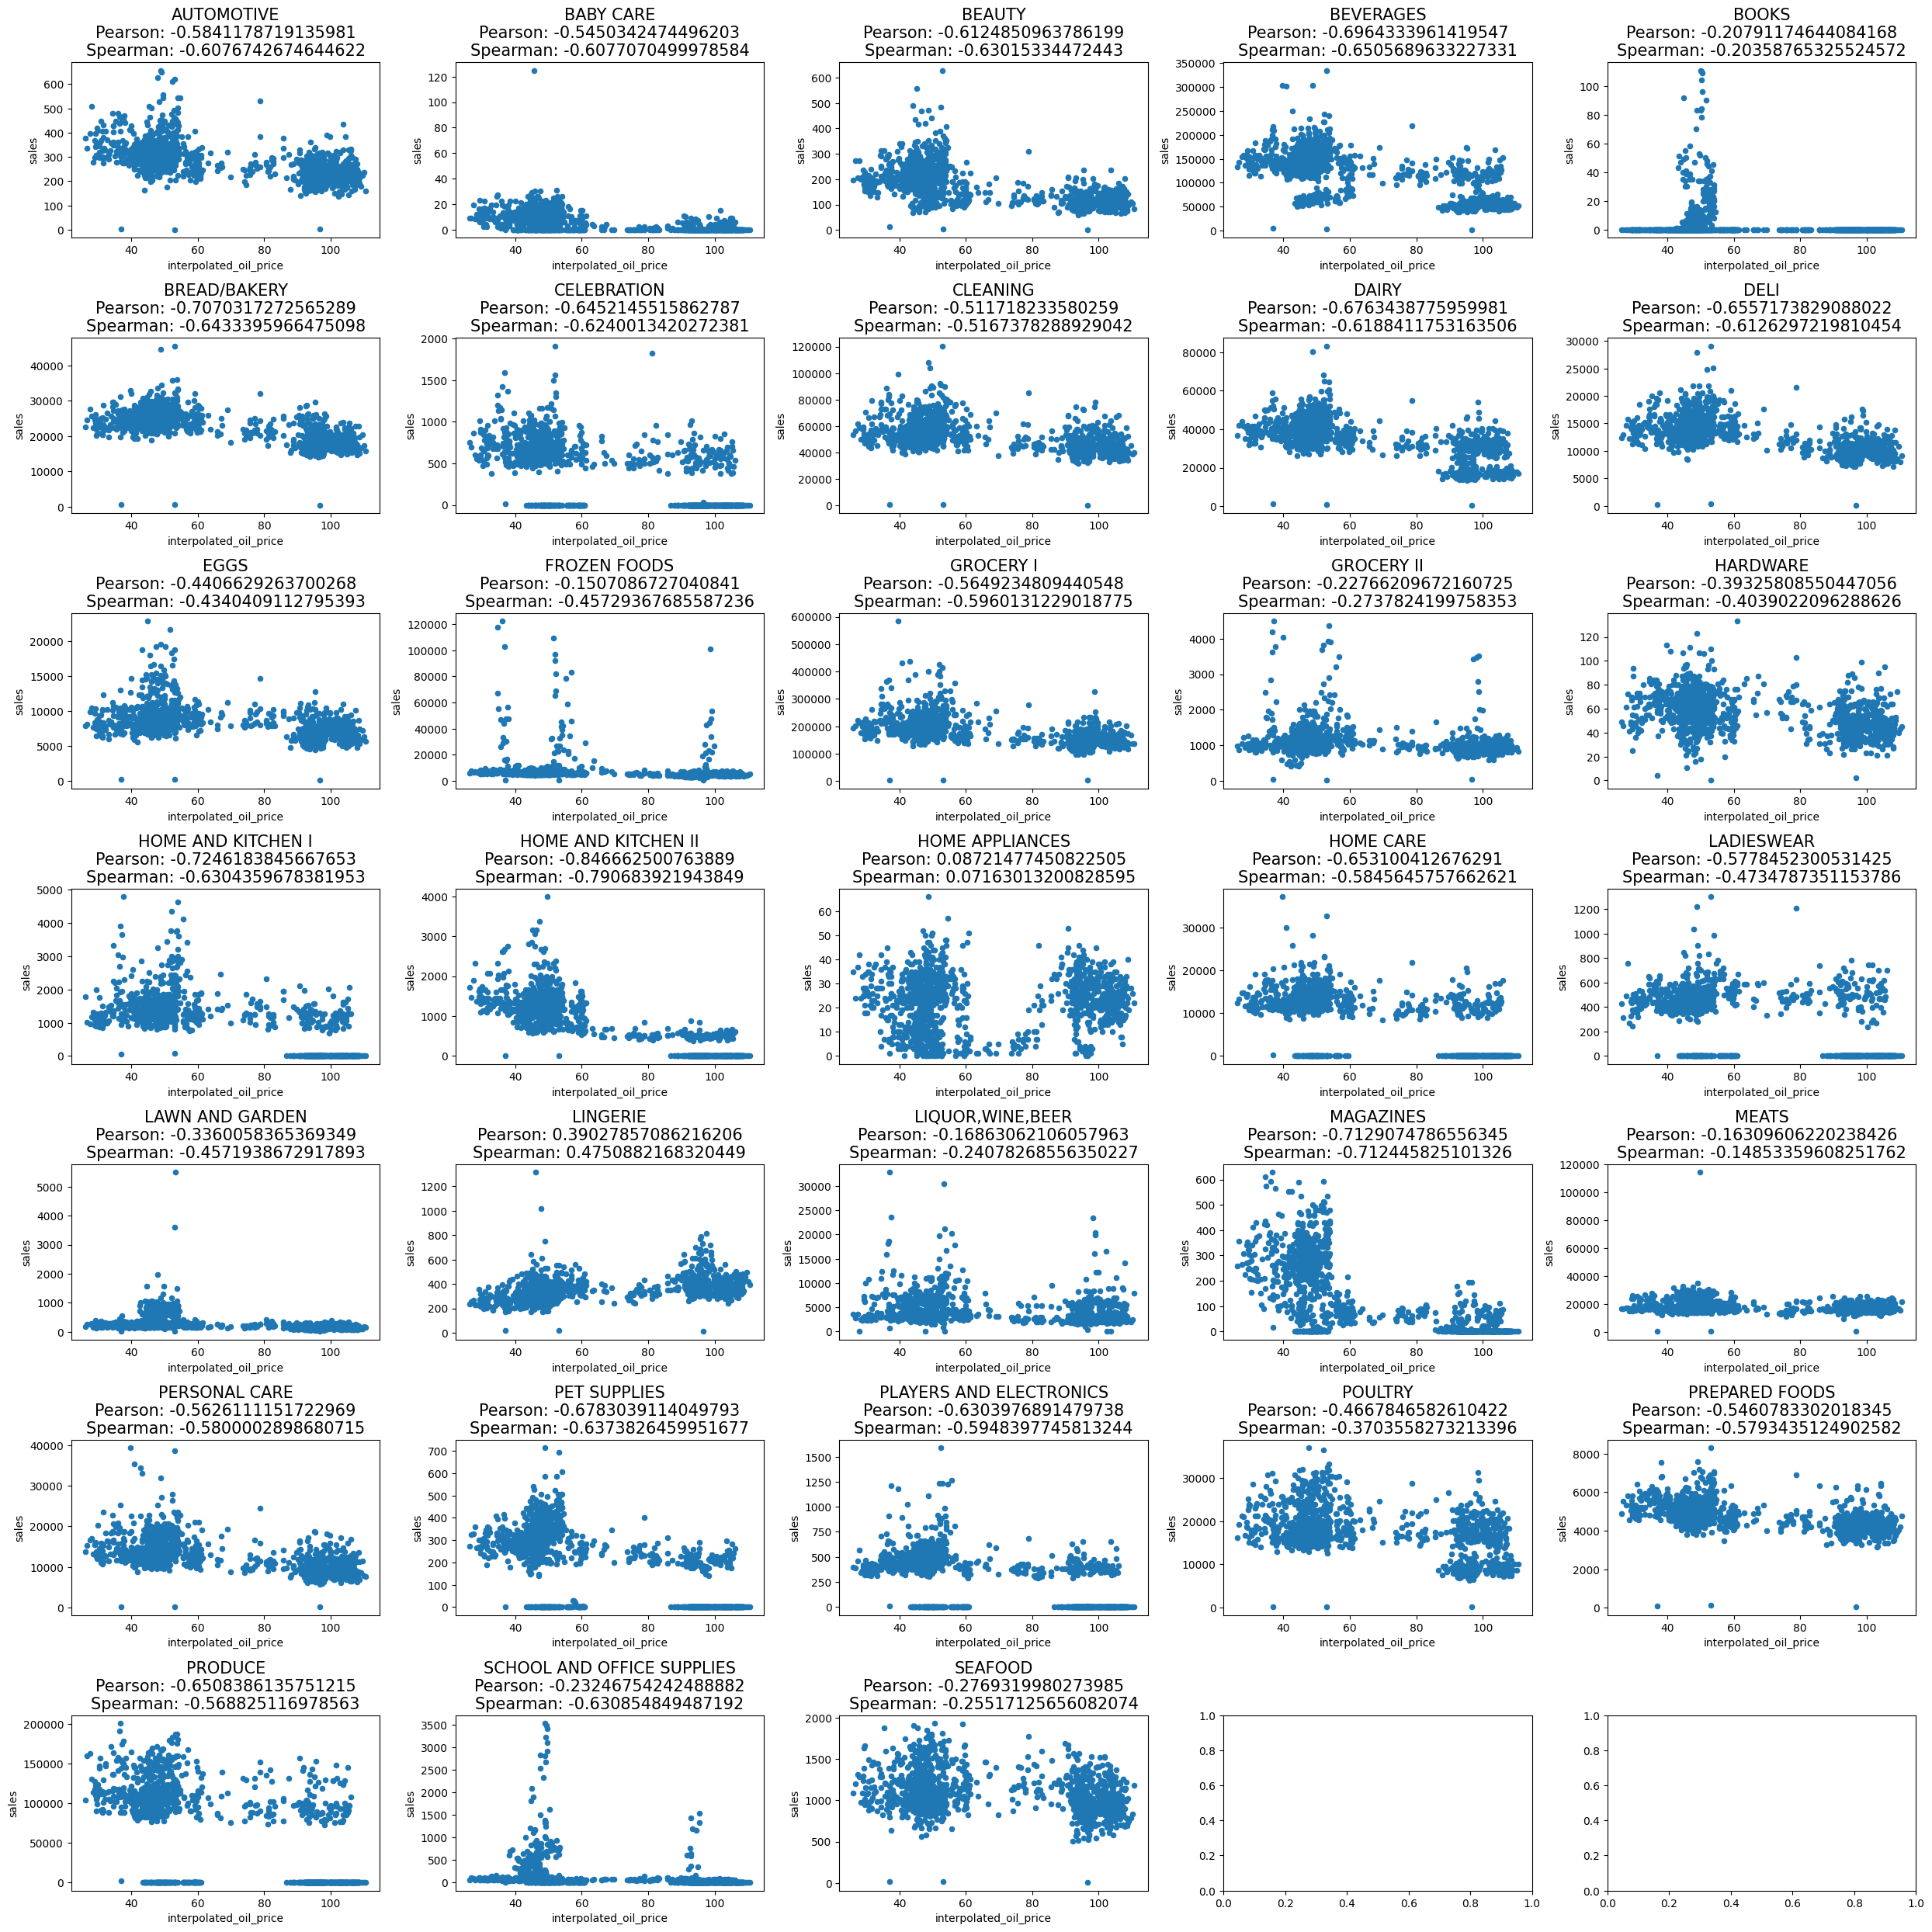

In [14]:
temp = train.copy()
temp = temp.groupby(["date","family"]).sum().reset_index()
temp = temp.merge(oil, on="date", how="left")

fig, axes = plt.subplots(7, 5, figsize = (25,25))
for i, family in enumerate(temp.family.unique()):
    temp_family = temp[temp.family == family]
    temp_family.plot.scatter(x = "interpolated_oil_price", y = "sales", ax=axes[i//5, i%5])
    pearson = temp_family[["interpolated_oil_price", "sales"]].corr().iloc[0,1]
    spearman = temp_family[["interpolated_oil_price", "sales"]].corr(method = "spearman").iloc[0,1]

    axes[i//5, i%5].set_title(family + "\nPearson: " + str(pearson) +"\nSpearman: " + str(spearman), fontsize = 15)

plt.tight_layout(pad=1.1)

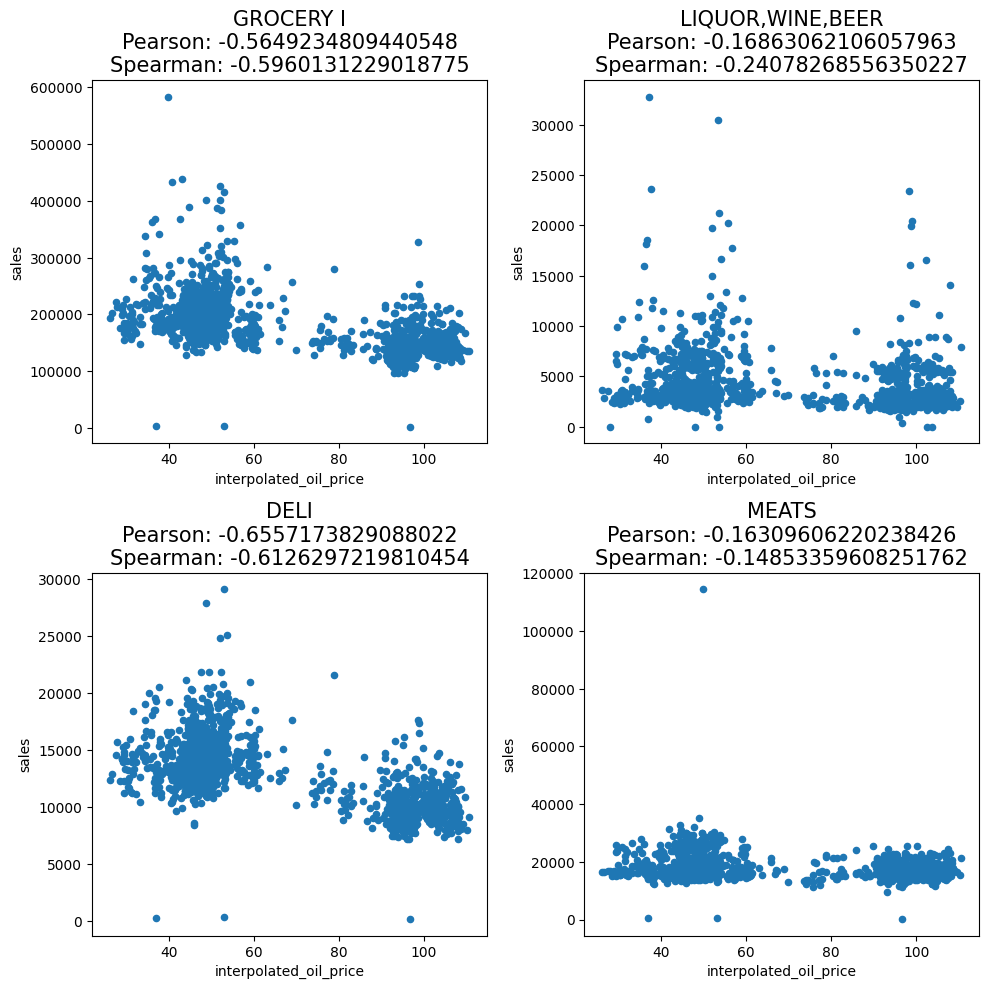

In [15]:
temp = train.copy()
temp = temp.groupby(["date","family"]).sum().reset_index()
temp = temp.merge(oil, on="date", how="left")

# print(temp.family.unique())

highlights = ["GROCERY I", "LIQUOR,WINE,BEER", "DELI", "MEATS"]

fig, axes = plt.subplots(2, 2, figsize = (10,10))
for i, family in enumerate(highlights):
    temp_family = temp[temp.family == family]
    temp_family.plot.scatter(x = "interpolated_oil_price", y = "sales", ax=axes[i//2, i%2])
    pearson = temp_family[["interpolated_oil_price", "sales"]].corr().iloc[0,1]
    spearman = temp_family[["interpolated_oil_price", "sales"]].corr(method = "spearman").iloc[0,1]

    axes[i//2, i%2].set_title(family + "\nPearson: " + str(pearson) +"\nSpearman: " + str(spearman), fontsize = 15)

plt.tight_layout(pad=1.1)

# Holidays or Outliers?

Let's take another look at transaction sales data.

            date  store_nbr  transactions
16908 2014-01-01         25           840
16909 2014-01-01         36           487
16910 2014-01-02          1          1875
16911 2014-01-02          2          2122
16912 2014-01-02          3          3350


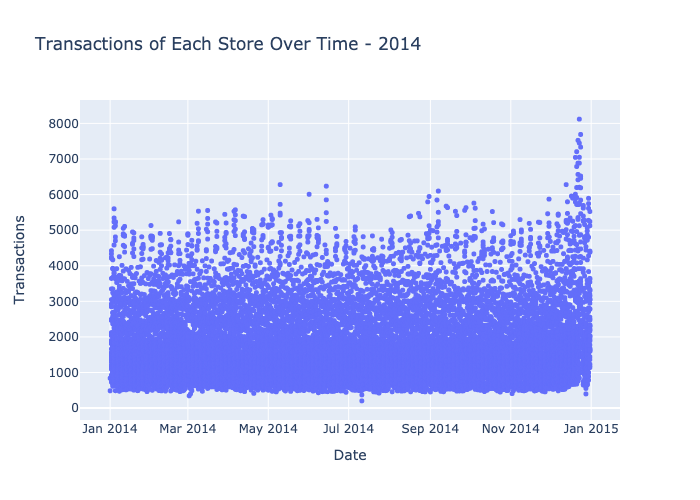

In [16]:
df = transactions.copy()

# Isolate 2014
df = df[df.date.dt.year == 2014]
print(df.head())

dotsize = 5

fig = go.Figure()

fig.add_trace(go.Scatter(x=df.date, y=df.transactions, mode='markers', marker=dict(size=dotsize), name='Transactions'))

fig.update_layout(title='Transactions of Each Store Over Time - 2014',
                     xaxis_title='Date',
                     yaxis_title='Transactions')

fig.show()

We can see a lot of spikes... Are those spikes outliers? What if we highlighted holidays...

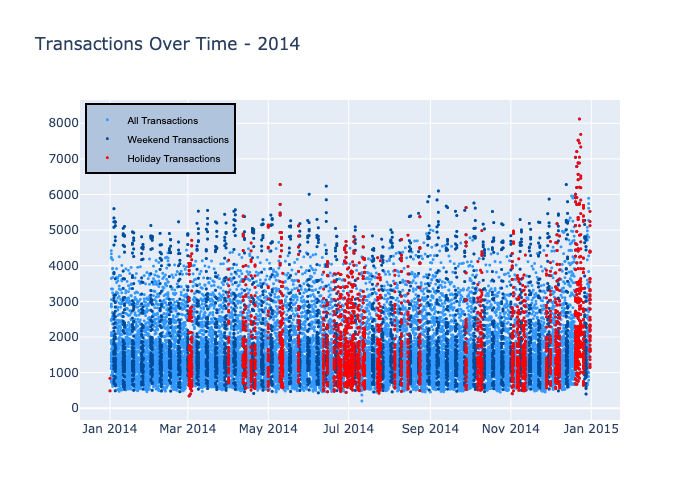

In [17]:
df = transactions.copy()

df = df.merge(holiday_events, on="date", how="left")

# Isolate 2014
df = df[df.date.dt.year == 2014]

df_weekends = df[df.date.dt.dayofweek >= 5]
df_holidays = df[df.type.notnull()]

# Create a figure
fig = go.Figure()

dotsize = 3

# Add a line for all transactions
fig.add_trace(go.Scatter(x=df['date'], y=df['transactions'], mode='markers', name='All Transactions', marker=dict(color='#3399FF', size=dotsize)))

# Add a line for weekend transactions
fig.add_trace(go.Scatter(x=df_weekends['date'], y=df_weekends['transactions'], mode='markers', name='Weekend Transactions', marker=dict(color='#004C99', size=dotsize)))

# Add a line for holiday transactions
fig.add_trace(go.Scatter(x=df_holidays['date'], y=df_holidays['transactions'], mode='markers', name='Holiday Transactions', marker=dict(color='red', size=dotsize)))

# Set the title
fig.update_layout(title='Transactions of Each Store Over Time - 2014')

fig.update_layout(
    title='Transactions Over Time - 2014',
    legend=dict(
        x=0.01,
        y=0.99,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=10,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

# Show the figure
fig.show()

In [18]:
df = transactions.copy()
df = df.merge(holiday_events, on="date", how="left")

# Print number of sales greater than threshold
threshold = 4500
print(f"Number of sales greater than {threshold}: {df[df.transactions > threshold].shape[0]}")

# Print number of sales greater than threshold that are on a holiday
print(f"Number of sales greater than {threshold} that are on a holiday: {df[(df.transactions > threshold) & (df.type.notnull())].shape[0]}")

# Print number of sales greater than threshold that are on a weekend
print(f"Number of sales greater than {threshold} that are on a weekend: {df[(df.transactions > threshold) & (df.date.dt.dayofweek >= 5)].shape[0]}")

# Print number of sales greater than threshold that are on a weekend and a holiday
print(f"Number of sales greater than {threshold} that are on a weekend and a holiday: {df[(df.transactions > threshold) & (df.date.dt.dayofweek >= 5) & (df.type.notnull())].shape[0]}")

# Print precentage of sales greater than threshold that are on a weekend or a holiday
total = df[df.transactions > threshold].shape[0]
weekend = df[(df.transactions > threshold) & (df.date.dt.dayofweek >= 5)].shape[0]
holiday = df[(df.transactions > threshold) & (df.type.notnull())].shape[0]
either = df[(df.transactions > threshold) & ((df.date.dt.dayofweek >= 5) | (df.type.notnull()))].shape[0]

print(f"Percentage of sales greater than {threshold} that are on a weekend: {weekend/total*100}%")
print(f"Percentage of sales greater than {threshold} that are on a holiday: {holiday/total*100}%")
print(f"Percentage of sales greater than {threshold} that are on a weekend or a holiday: {either/total*100}%")

Number of sales greater than 4500: 1691
Number of sales greater than 4500 that are on a holiday: 446
Number of sales greater than 4500 that are on a weekend: 1297
Number of sales greater than 4500 that are on a weekend and a holiday: 222
Percentage of sales greater than 4500 that are on a weekend: 76.70017740981667%
Percentage of sales greater than 4500 that are on a holiday: 26.37492607924305%
Percentage of sales greater than 4500 that are on a weekend or a holiday: 89.94677705499704%


As we can see, many of the spikes are attributed to weekends and holidays. Since we know when those days are, we can just add those days as features in our models!

# Other Time Features

## Lag

We'll start with lag features. Lag features are just values from previous time periods. For example, the sales from the previous day, or the sales from the same day last year.

In [19]:
# def plot_families(temp, axes):
#     fig, axes = plt.subplots(7, 5, figsize = (25,25))

#     for i, family in enumerate(temp.family.unique()):
#         temp_family = temp[temp.family == family]
#         temp_family.plot.scatter(x = "day_lag_sales", y = "sales", ax=axes[i//5, i%5])
#         pearson = temp_family[["day_lag_sales", "sales"]].corr().iloc[0,1]
#         spearman = temp_family[["day_lag_sales", "sales"]].corr(method = "spearman").iloc[0,1]

#         axes[i//5, i%5].set_title(family + "\nPearson: " + str(pearson) +"\nSpearman: " + str(spearman), fontsize = 15)

#     plt.tight_layout(pad=1.1)
#     plt.show()

# temp = train.copy()
# temp = temp.groupby(["date","family"]).sum().reset_index()

# lag = [1,7,14,30,365]

# for lag in lag:
#     temp["day_lag_sales"] = temp["sales"].shift(lag)
#     plot_families(temp, axes)

We can see it's a mixed bag of high correlations and low correlations. Generally though, the lag features appear useful!

# Predictions

## Data Preprocessing

In [20]:
training = train.copy()

In [21]:
# Add Time Features
training["year"] = training.date.dt.year
training["month"] = training.date.dt.month
days_of_the_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, day in enumerate(days_of_the_week):
    training[day] = (training.date.dt.dayofweek == i).astype("float16")

print(training.head())

   id       date  store_nbr      family  sales  onpromotion  year  month  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0
1   1 2013-01-01          1   BABY CARE    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0
2   2 2013-01-01          1      BEAUTY    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0
3   3 2013-01-01          1   BEVERAGES    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0
4   4 2013-01-01          1       BOOKS    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0


In [22]:
# Add Oil Price
training = training.merge(oil, on="date", how="left")
training["oil_price"] = training["interpolated_oil_price"]
del training["interpolated_oil_price"]
print(training.head())

   id       date  store_nbr      family  sales  onpromotion  year  month  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  oil_price
0   0 2013-01-01          1  AUTOMOTIVE    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0        NaN
1   1 2013-01-01          1   BABY CARE    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0        NaN
2   2 2013-01-01          1      BEAUTY    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0        NaN
3   3 2013-01-01          1   BEVERAGES    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0        NaN
4   4 2013-01-01          1       BOOKS    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.0     0.0        NaN


In [23]:
# Split store_nbr into columns
store_nbr = pd.get_dummies(training.store_nbr, prefix="store_nbr", dtype="float16")
training = pd.concat([training, store_nbr], axis=1)
del training["store_nbr"]
print(training.head())

   id       date      family  sales  onpromotion  year  month  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  oil_price  store_nbr_1  store_nbr_2  store_nbr_3  store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  store_nbr_8  store_nbr_9  store_nbr_10  store_nbr_11  store_nbr_12  store_nbr_13  store_nbr_14  store_nbr_15  store_nbr_16  store_nbr_17  store_nbr_18  store_nbr_19  store_nbr_20  store_nbr_21  store_nbr_22  store_nbr_23  store_nbr_24  store_nbr_25  store_nbr_26  store_nbr_27  store_nbr_28  store_nbr_29  store_nbr_30  store_nbr_31  store_nbr_32  store_nbr_33  store_nbr_34  store_nbr_35  store_nbr_36  store_nbr_37  store_nbr_38  store_nbr_39  store_nbr_40  store_nbr_41  store_nbr_42  store_nbr_43  store_nbr_44  store_nbr_45  store_nbr_46  store_nbr_47  store_nbr_48  store_nbr_49  store_nbr_50  store_nbr_51  store_nbr_52  store_nbr_53  store_nbr_54
0   0 2013-01-01  AUTOMOTIVE    0.0          0.0  2013      1     0.0      1.0        0.0       0.0     0.0       0.

In [24]:
# Split family into columns
family = pd.get_dummies(training.family, prefix="family", dtype="float16")
training = pd.concat([training, family], axis=1)
del training["family"]
print(training.head())

   id       date  sales  onpromotion  year  month  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  oil_price  store_nbr_1  store_nbr_2  store_nbr_3  store_nbr_4  store_nbr_5  store_nbr_6  store_nbr_7  store_nbr_8  store_nbr_9  store_nbr_10  store_nbr_11  store_nbr_12  store_nbr_13  store_nbr_14  store_nbr_15  store_nbr_16  store_nbr_17  store_nbr_18  store_nbr_19  store_nbr_20  store_nbr_21  store_nbr_22  store_nbr_23  store_nbr_24  store_nbr_25  store_nbr_26  store_nbr_27  store_nbr_28  store_nbr_29  store_nbr_30  store_nbr_31  store_nbr_32  store_nbr_33  store_nbr_34  store_nbr_35  store_nbr_36  store_nbr_37  store_nbr_38  store_nbr_39  store_nbr_40  store_nbr_41  store_nbr_42  store_nbr_43  store_nbr_44  store_nbr_45  store_nbr_46  store_nbr_47  store_nbr_48  store_nbr_49  store_nbr_50  store_nbr_51  store_nbr_52  store_nbr_53  store_nbr_54  family_AUTOMOTIVE  family_BABY CARE  family_BEAUTY  family_BEVERAGES  family_BOOKS  family_BREAD/BAKERY  family_CELEBRATION  fa

In [25]:
# Add Holiday Events
holidays = holiday_events.copy()
holidays["date"] = pd.to_datetime(holidays["date"])
holidays.drop(["description", "locale_name"], axis=1, inplace=True)
print(training.isna().sum())

# Make each holiday a separate column
# df = pd.get_dummies(df, columns=['type'], dummy_na=False, prefix='holidayType')
# df = pd.get_dummies(df, columns=['locale'], dummy_na=False, prefix='holidayLocale')
# df = pd.get_dummies(df, columns=['transferred'], dummy_na=False, prefix='holidayTransferred')

holidays = pd.get_dummies(holidays, columns=['type'], dummy_na=False, prefix='holidayType', dtype="float16")
holidays = pd.get_dummies(holidays, columns=['locale'], dummy_na=False, prefix='holidayLocale', dtype="float16")
holidays = pd.get_dummies(holidays, columns=['transferred'], dummy_na=False, prefix='holidayTransferred', dtype="float16")

# Merge with training data
training = training.merge(holidays, on="date", how="left")

# Fill NaNs
training.fillna(0, inplace=True)

id                                   0
date                                 0
sales                                0
onpromotion                          0
year                                 0
                                    ..
family_POULTRY                       0
family_PREPARED FOODS                0
family_PRODUCE                       0
family_SCHOOL AND OFFICE SUPPLIES    0
family_SEAFOOD                       0
Length: 101, dtype: int64


In [26]:
# Split Training and Testing Data Use August 2016 as split date
X_train = training[training.date < "2016-08-01"]
X_test = training[training.date >= "2016-08-01"]

y_train = X_train["sales"]
y_test = X_test["sales"]

# Drop date
del X_train["date"]
del X_test["date"]

# Drop sales
del X_train["sales"]
del X_test["sales"]

# Drop id
del X_train["id"]
del X_test["id"]

# Save X_train columns
X_train_columns = X_train.columns

In [27]:
# Print ALL columns of X_train
print("Columns of X_train: " + str(len(X_train.columns)))

for col in X_train.columns:
    print(col)

Columns of X_train: 109
onpromotion
year
month
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday
oil_price
store_nbr_1
store_nbr_2
store_nbr_3
store_nbr_4
store_nbr_5
store_nbr_6
store_nbr_7
store_nbr_8
store_nbr_9
store_nbr_10
store_nbr_11
store_nbr_12
store_nbr_13
store_nbr_14
store_nbr_15
store_nbr_16
store_nbr_17
store_nbr_18
store_nbr_19
store_nbr_20
store_nbr_21
store_nbr_22
store_nbr_23
store_nbr_24
store_nbr_25
store_nbr_26
store_nbr_27
store_nbr_28
store_nbr_29
store_nbr_30
store_nbr_31
store_nbr_32
store_nbr_33
store_nbr_34
store_nbr_35
store_nbr_36
store_nbr_37
store_nbr_38
store_nbr_39
store_nbr_40
store_nbr_41
store_nbr_42
store_nbr_43
store_nbr_44
store_nbr_45
store_nbr_46
store_nbr_47
store_nbr_48
store_nbr_49
store_nbr_50
store_nbr_51
store_nbr_52
store_nbr_53
store_nbr_54
family_AUTOMOTIVE
family_BABY CARE
family_BEAUTY
family_BEVERAGES
family_BOOKS
family_BREAD/BAKERY
family_CELEBRATION
family_CLEANING
family_DAIRY
family_DELI
family_EGGS
family_FROZEN FOODS
fa

In [28]:
# Normalize using SKLearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [29]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Score the model
train_score = lin_reg.score(X_train, y_train)
val_score = lin_reg.score(X_test, y_test)

print(f'Training score R^2: {train_score}')
print(f'Validation score R^2: {val_score}')

Training score R^2: 0.5597552647062024
Validation score R^2: 0.6123045686694635


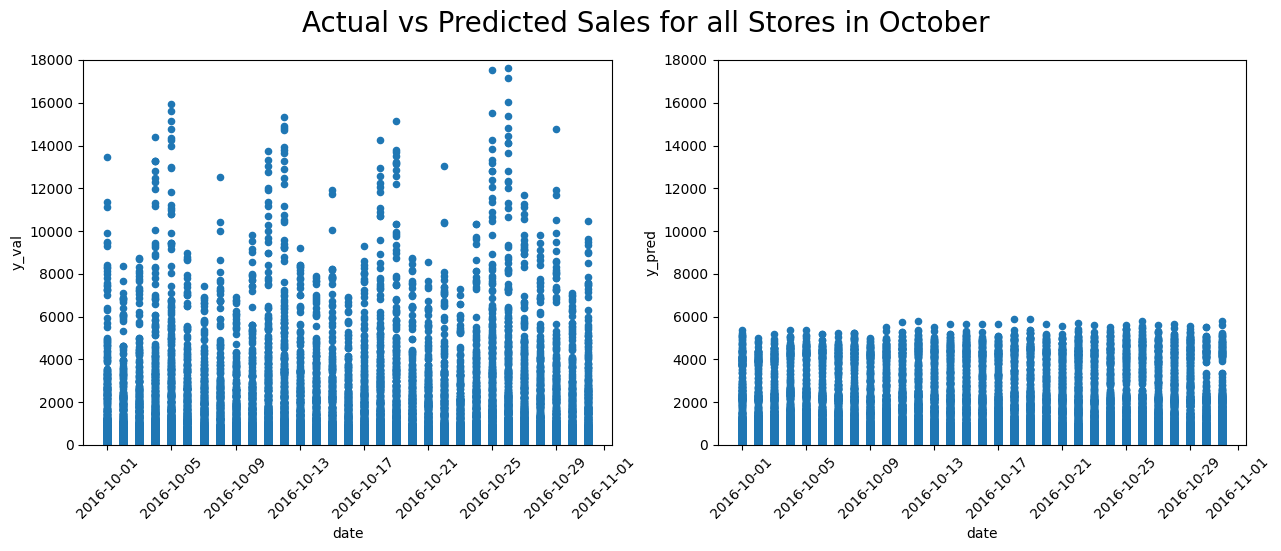

In [30]:
# Plot the predictions

df = pd.DataFrame({'y_val': y_test, 'y_pred': lin_reg.predict(X_test)})

df.index.name = 'id'

df = df.merge(train, on="id", how="left")

df = df.sort_values("date")

# Do the same, but just for the month of October
df = df[df.date.dt.month == 10]

fig, axes = plt.subplots(1, 2, figsize = (15,5))
df.plot(x = "date", y = "y_val", ax=axes[0], kind="scatter")
df.plot(x = "date", y = "y_pred", ax=axes[1], kind="scatter")

axes[0].set_ylim([0, 18000])
axes[1].set_ylim([0, 18000])

# Rotate the x-axis labels
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


fig.suptitle('Actual vs Predicted Sales for all Stores in October', fontsize = 20)

plt.show()

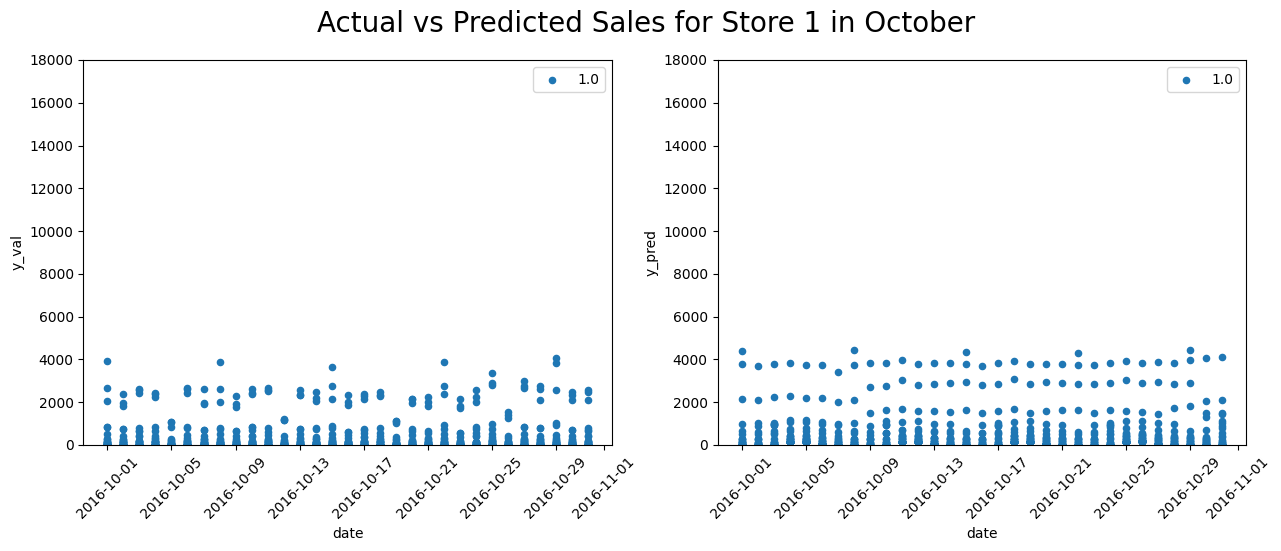

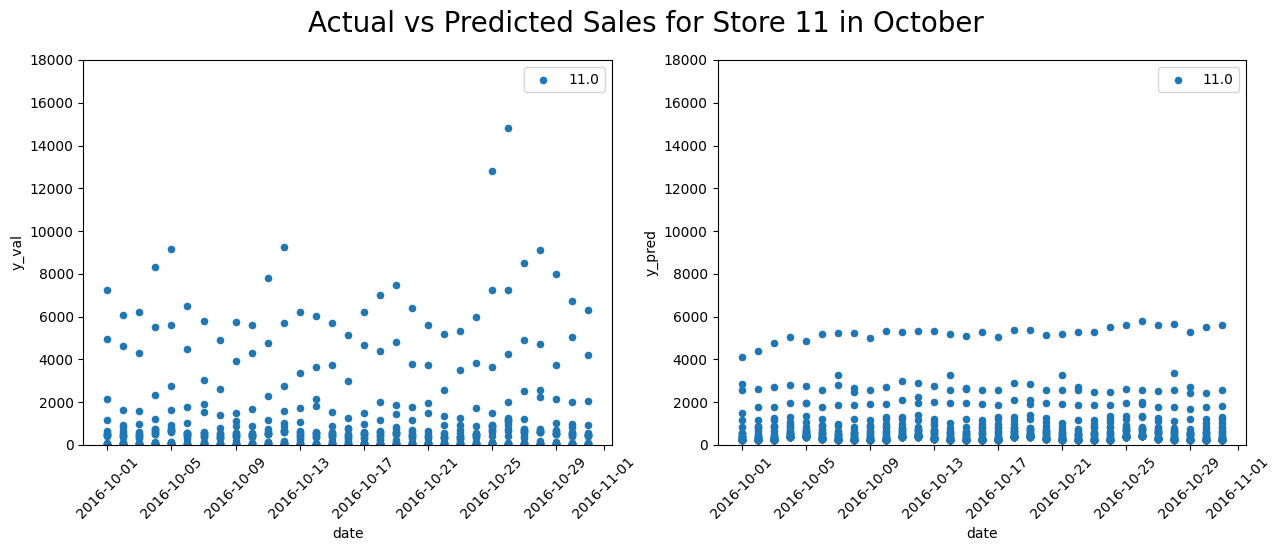

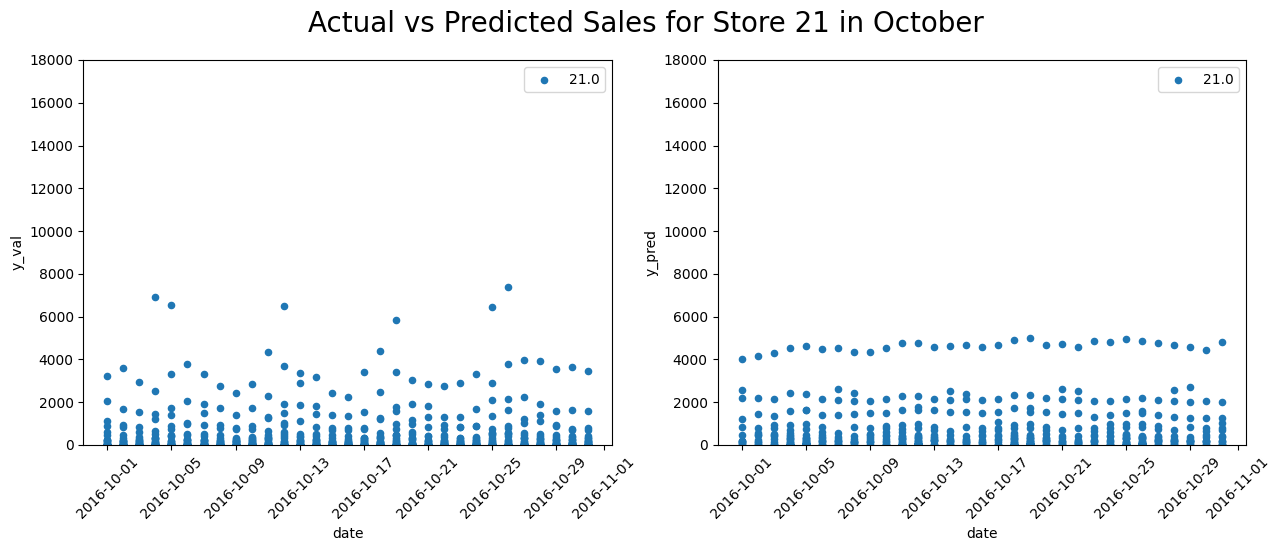

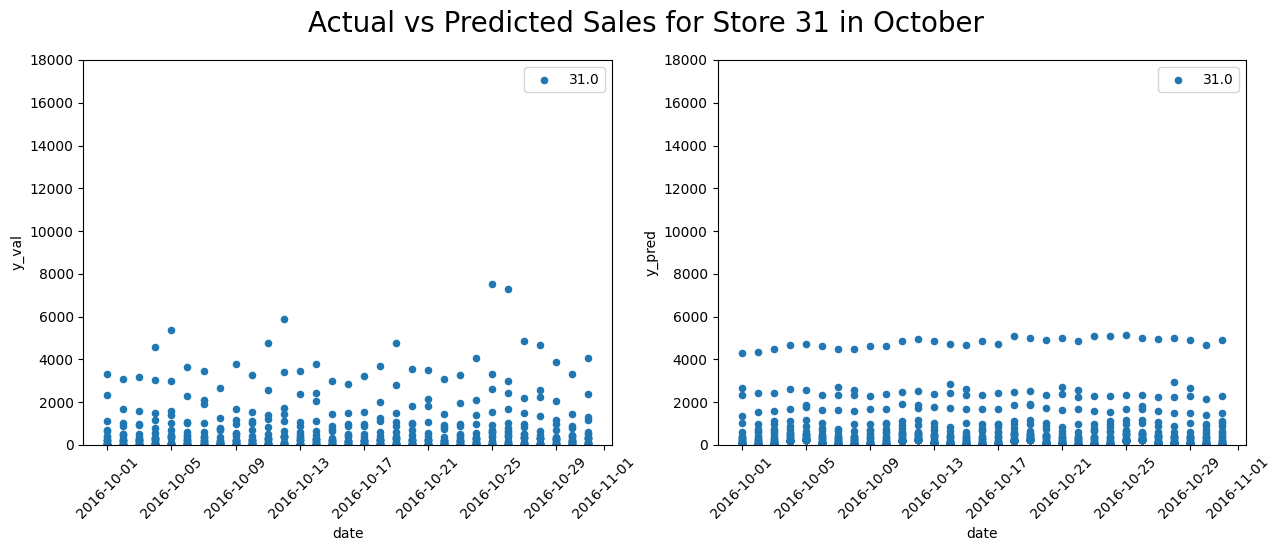

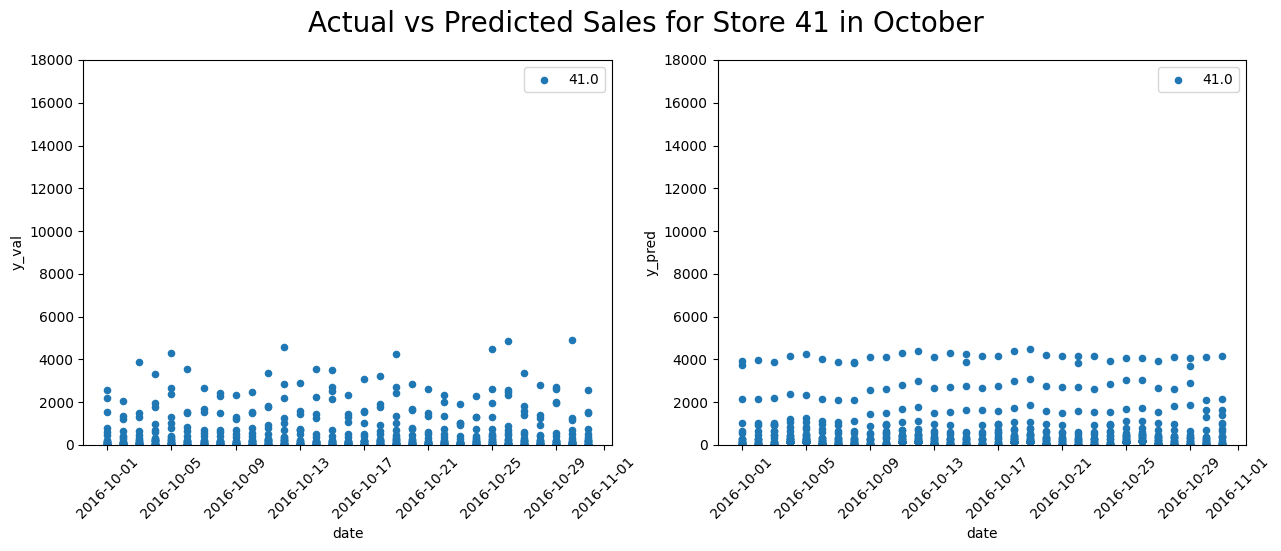

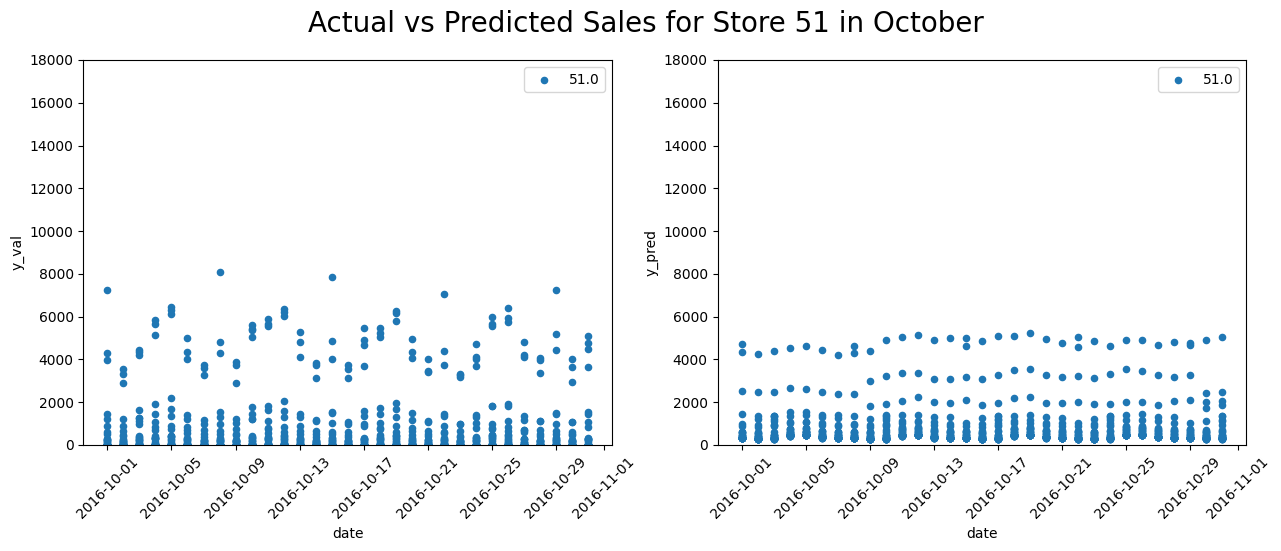

In [31]:
df = pd.DataFrame({'y_val': y_test, 'y_pred': lin_reg.predict(X_test)})

df.index.name = 'id'

df = df.merge(train, on="id", how="left")

df = df.sort_values("date")

# Isolate October
df = df[df.date.dt.month == 10]

for(store_nbr, data) in df.groupby("store_nbr"):
    if(store_nbr%10 == 1):
        fig, axes = plt.subplots(1, 2, figsize = (15,5))
        data.plot(x = "date", y = "y_val", ax=axes[0], kind="scatter", label=store_nbr)
        data.plot(x = "date", y = "y_pred", ax=axes[1], kind="scatter", label=store_nbr)

        axes[0].set_ylim([0, 18000])
        axes[1].set_ylim([0, 18000])

        # Rotate the x-axis labels
        for ax in axes:
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)

    fig.suptitle('Actual vs Predicted Sales for Store ' + str(int(store_nbr)) + ' in October', fontsize = 20)

    plt.show()

## Gradient Boosting

In [53]:
import xgboost as xgb

reg = xgb.XGBRegressor(n_estimators=200,early_stopping_rounds=25,learning_rate=0.1)
reg.fit(X_train,y_train,
       eval_set=[(X_train,y_train)],
       verbose=10)

# Score the model
train_score = reg.score(X_train, y_train)
val_score = reg.score(X_test, y_test)

print(f'Training score: {train_score}')
print(f'Validation score: {val_score}')

# Display model information
print(reg)

[0]	validation_0-rmse:959.53612
[10]	validation_0-rmse:625.51663
[20]	validation_0-rmse:529.32999
[30]	validation_0-rmse:487.06147
[40]	validation_0-rmse:457.86805
[50]	validation_0-rmse:439.29318
[60]	validation_0-rmse:425.61069
[70]	validation_0-rmse:413.61101
[80]	validation_0-rmse:402.73328
[90]	validation_0-rmse:393.88010
[100]	validation_0-rmse:387.42174
[110]	validation_0-rmse:380.90618
[120]	validation_0-rmse:375.84966
[130]	validation_0-rmse:372.03346
[140]	validation_0-rmse:367.92187
[150]	validation_0-rmse:364.20647
[160]	validation_0-rmse:360.95669
[170]	validation_0-rmse:357.70628
[180]	validation_0-rmse:354.70337
[190]	validation_0-rmse:349.13914
[199]	validation_0-rmse:346.30666
Training score: 0.8860029782136719
Validation score: 0.8933835211479486
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=25,
             enable_categorica

In [46]:
# # Plot the first decision tree
# plt.figure(figsize=(10, 1))  # Adjust figure size as needed
# xgb.plot_tree(reg, num_trees=0)
# plt.savefig('tree_0.png', dpi=5000)  # Adjust dpi as needed
# plt.close()

<Figure size 1000x100 with 0 Axes>

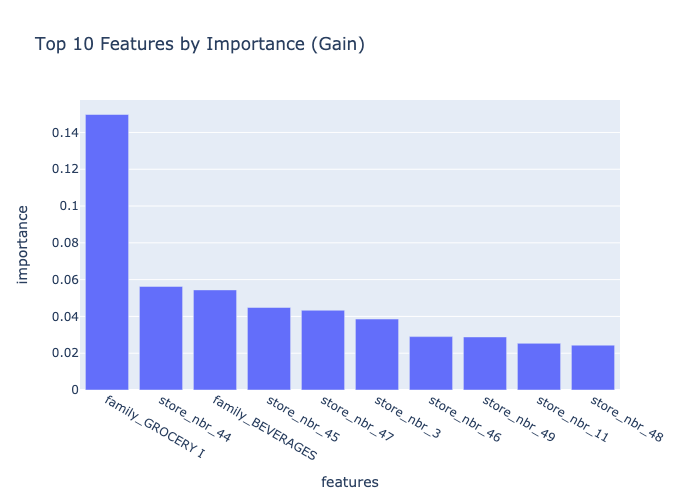

In [58]:
# Use plotly to plot the feature importances
importance = reg.feature_importances_
features = X_train_columns

df = pd.DataFrame({"features":features, "importance":importance})
df = df.sort_values("importance", ascending=False)

df = df.head(10)

px.bar(df, x="features", y="importance", title="Top 10 Features by Importance (Gain)")

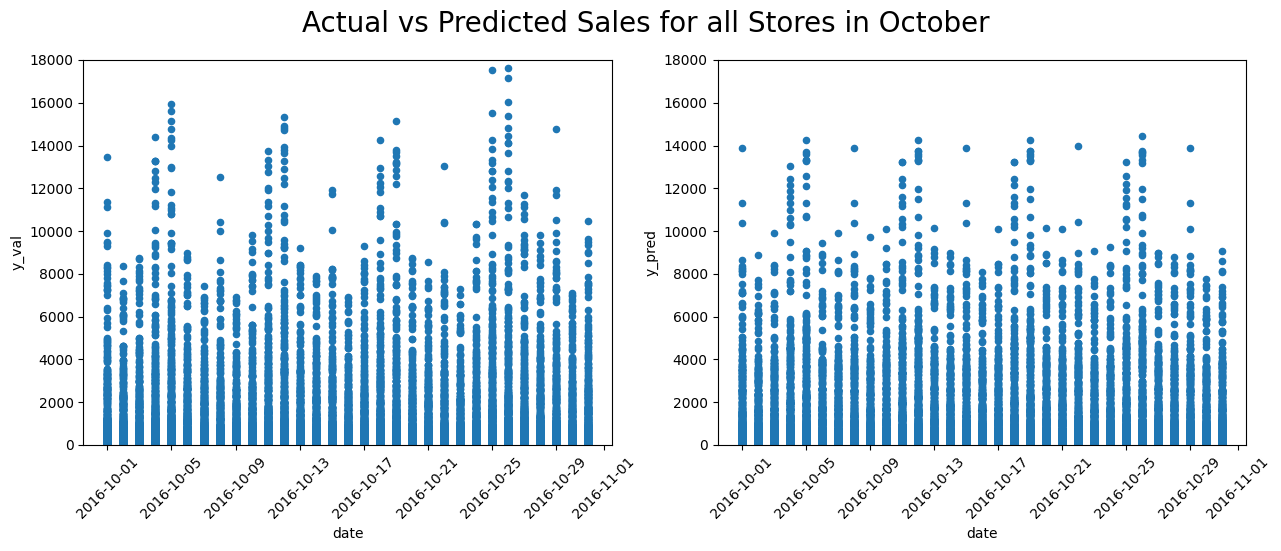

In [55]:
# Plot the predictions

df = pd.DataFrame({'y_val': y_test, 'y_pred': reg.predict(X_test)})

df.index.name = 'id'

df = df.merge(train, on="id", how="left")

df = df.sort_values("date")
# print(df.head(30))

# fig, axes = plt.subplots(1, 2, figsize = (15,5))
# df.plot(x = "date", y = "y_val", ax=axes[0])
# df.plot(x = "date", y = "y_pred", ax=axes[1])

# axes[0].set_ylim([0, 18000])
# axes[1].set_ylim([0, 18000])

# plt.show()

# Do the same, but just for the month of October
df = df[df.date.dt.month == 10]

fig, axes = plt.subplots(1, 2, figsize = (15,5))
df.plot(x = "date", y = "y_val", ax=axes[0], kind="scatter")
df.plot(x = "date", y = "y_pred", ax=axes[1], kind="scatter")

axes[0].set_ylim([0, 18000])
axes[1].set_ylim([0, 18000])

# Rotate the x-axis labels
for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)


fig.suptitle('Actual vs Predicted Sales for all Stores in October', fontsize = 20)

plt.show()

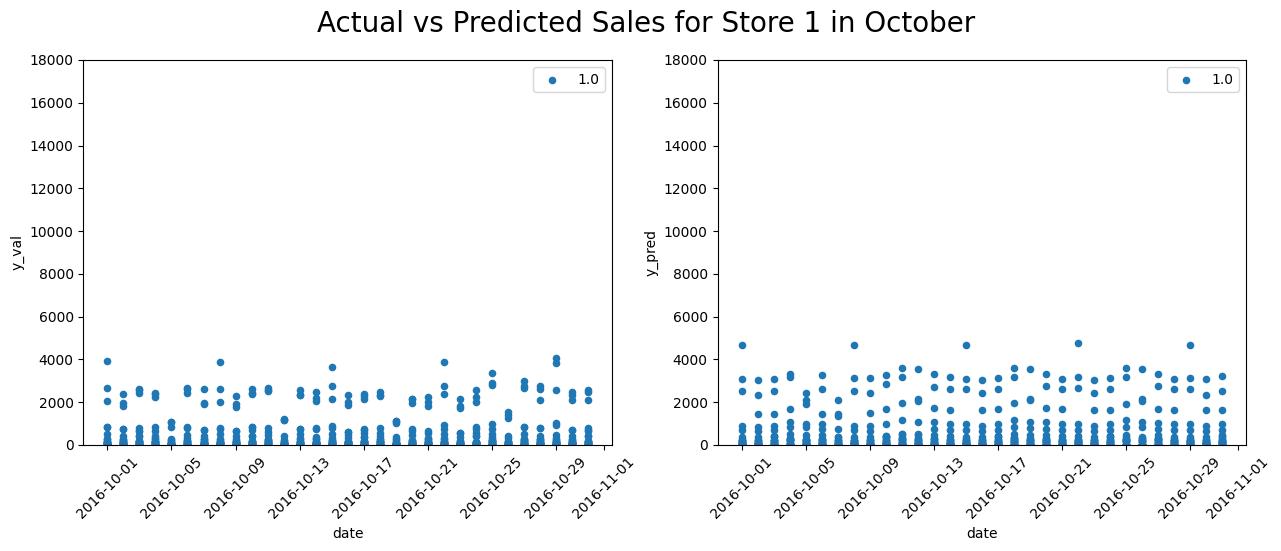

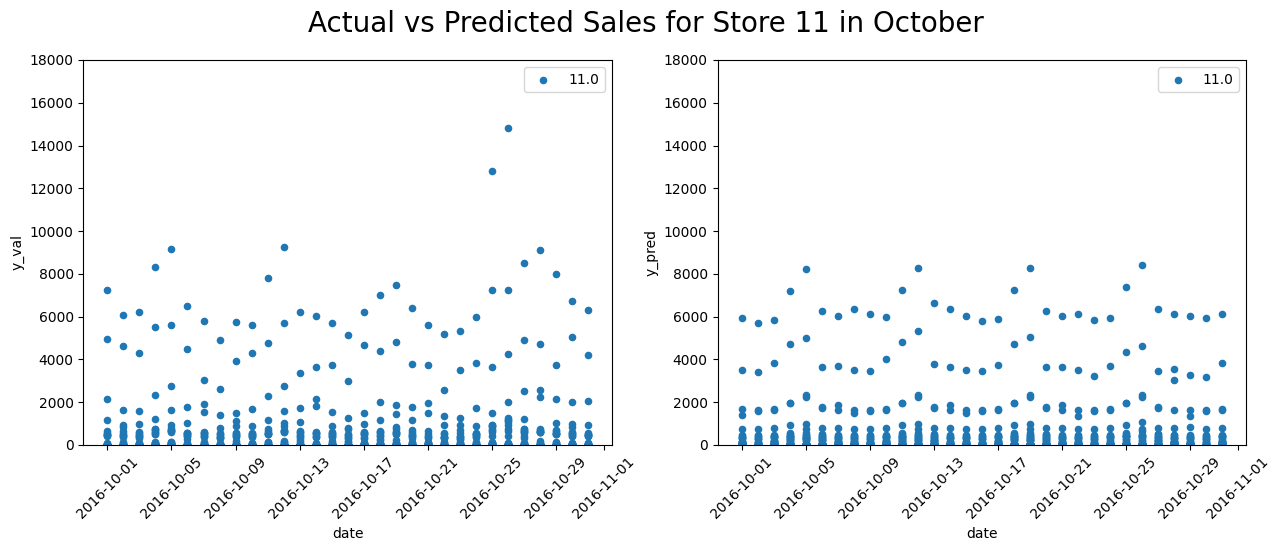

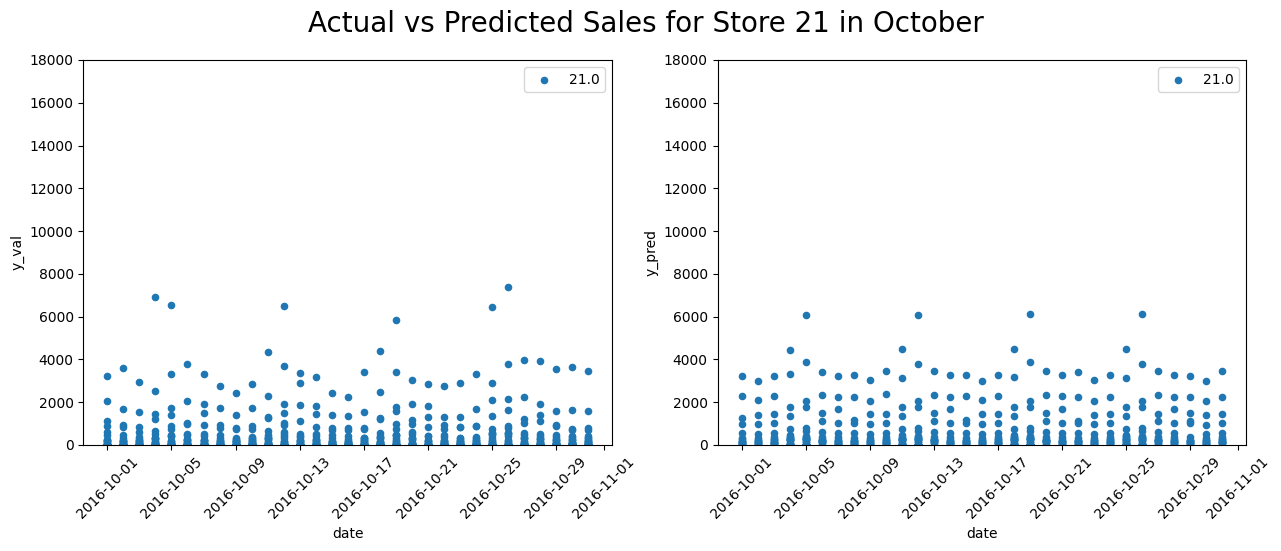

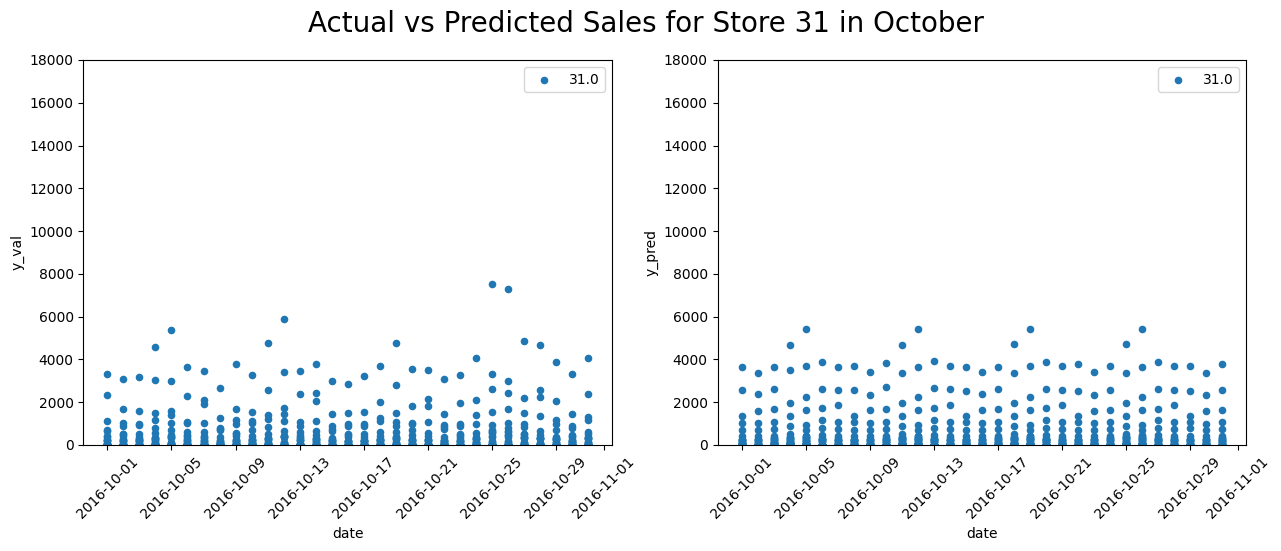

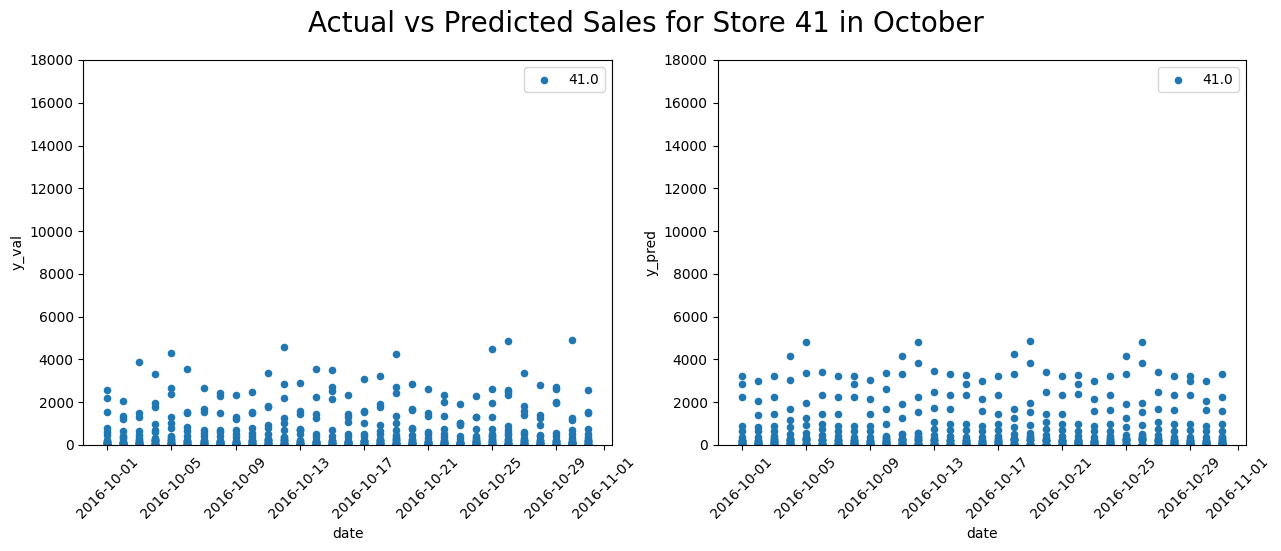

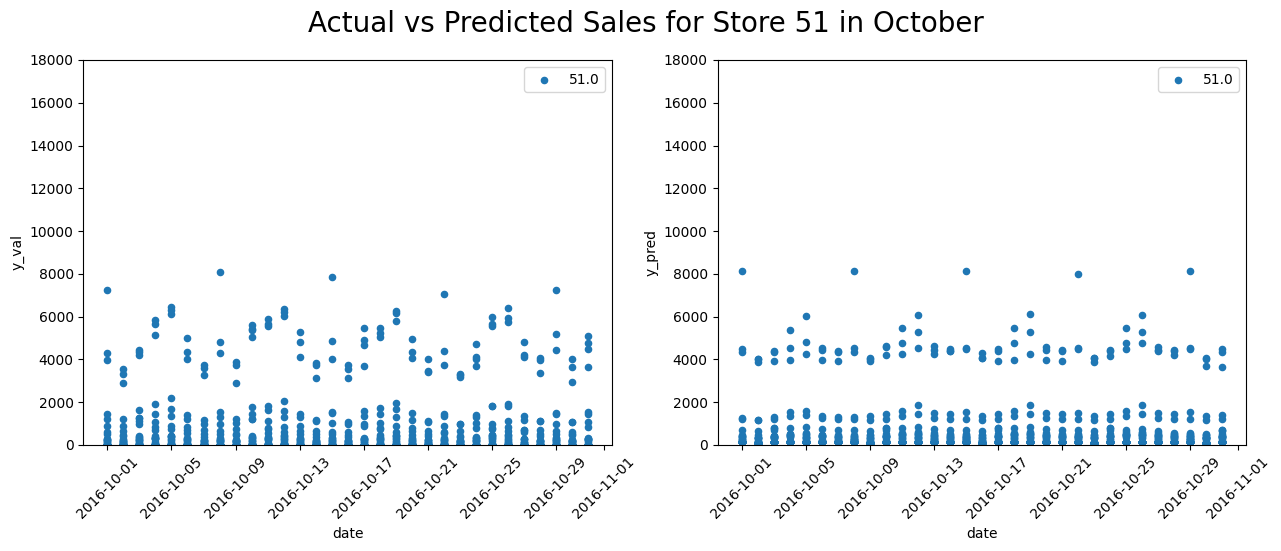

In [56]:
df = pd.DataFrame({'y_val': y_test, 'y_pred': reg.predict(X_test)})

df.index.name = 'id'

df = df.merge(train, on="id", how="left")

df = df.sort_values("date")

# Isolate October
df = df[df.date.dt.month == 10]

for(store_nbr, data) in df.groupby("store_nbr"):
    if(store_nbr%10 == 1):
        fig, axes = plt.subplots(1, 2, figsize = (15,5))
        data.plot(x = "date", y = "y_val", ax=axes[0], kind="scatter", label=store_nbr)
        data.plot(x = "date", y = "y_pred", ax=axes[1], kind="scatter", label=store_nbr)

        axes[0].set_ylim([0, 18000])
        axes[1].set_ylim([0, 18000])

        # Rotate the x-axis labels
        for ax in axes:
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)

    fig.suptitle('Actual vs Predicted Sales for Store ' + str(int(store_nbr)) + ' in October', fontsize = 20)

    plt.show()

## Support Vector Machine

In [57]:
# # Support Vector Machine
# from sklearn.svm import SVR

# svr = SVR()
# svr.fit(X_train, y_train)

# # Score the model
# train_score = svr.score(X_train, y_train)
# val_score = svr.score(X_test, y_test)

# print(f'Training score: {train_score}')
# print(f'Validation score: {val_score}')